### Dedupe needs more setup therefore a notebook so i can handle it step by Step


In [2]:
import rdflib

ttl_path = "data/healthcare_graph_Main.ttl"

def extract_dedupe_fields_from_ttl(ttl_path):
    g = rdflib.Graph()
    g.parse(ttl_path)
    
    # Map: {entity_type: set([literal_predicate_names])}
    type_predicate_map = {}
    
    for s in set(g.subjects()):
        # Get type
        types = [str(o) for o in g.objects(s, rdflib.RDF.type)]
        if not types:
            continue
        type_ = types[0].split("/")[-1]  # Or use more sophisticated logic if needed
        
        # Gather literal predicates
        predicates = set()
        for p, o in g.predicate_objects(s):
            if isinstance(o, rdflib.Literal):
                pred_name = p.split("/")[-1] if "/" in str(p) else str(p)
                predicates.add(pred_name)
        if type_ not in type_predicate_map:
            type_predicate_map[type_] = set()
        type_predicate_map[type_].update(predicates)
    
    # Build dedupe.io field definitions per entity type
    dedupe_fields = {}
    for type_, preds in type_predicate_map.items():
        dedupe_fields[type_] = [
            {'field': pred, 'type': 'String'} for pred in preds if pred.lower() != "identifier"
]

    return dedupe_fields

fields_per_type = extract_dedupe_fields_from_ttl("data/healthcare_graph_Main.ttl")
for entity_type, fields in fields_per_type.items():
    print(f"Entity type: {entity_type}")
    print(fields)
    print()

Entity type: ContactPoint
[{'field': 'availableLanguage', 'type': 'String'}, {'field': 'faxNumber', 'type': 'String'}, {'field': 'email', 'type': 'String'}, {'field': 'telephone', 'type': 'String'}, {'field': 'contactType', 'type': 'String'}]

Entity type: Person
[{'field': 'birthDate', 'type': 'String'}, {'field': 'jobTitle', 'type': 'String'}, {'field': 'name', 'type': 'String'}, {'field': 'email', 'type': 'String'}, {'field': 'gender', 'type': 'String'}, {'field': 'knowsLanguage', 'type': 'String'}]

Entity type: PostalAddress
[{'field': 'addressCountry', 'type': 'String'}, {'field': 'streetAddress', 'type': 'String'}, {'field': 'postalCode', 'type': 'String'}, {'field': 'addressLocality', 'type': 'String'}]

Entity type: Department
[{'field': 'name', 'type': 'String'}]

Entity type: MedicalOrganization
[{'field': 'name', 'type': 'String'}]



In [29]:
from modular_methods.graphToText_utils import kg_to_dedupe_dict
g = rdflib.Graph() # Main graph
g1 = rdflib.Graph() # Replaced low graph
g2 = rdflib.Graph() # Train graph
g3 = rdflib.Graph() # Replaced medium graph
g4 = rdflib.Graph() # Replaced high graph
g5 = rdflib.Graph() # Struct low graph
g6 = rdflib.Graph() # Struct high graph
g7 = rdflib.Graph() # Struct train_low graph
g8 = rdflib.Graph() # Struct train_high graph

g.parse("data/healthcare_graph_Main.ttl")
g1.parse("data/healthcare_graph_replaced_low.ttl")
g2.parse("data/healthcare_graph_train.ttl")
g3.parse("data/healthcare_graph_replaced_medium.ttl")
g4.parse("data/healthcare_graph_replaced_high.ttl")
g5.parse("data/healthcare_graph_struct_low.ttl")
g6.parse("data/healthcare_graph_struct_high.ttl")
g7.parse("data/healthcare_graph_train_struct_low.ttl")
g8.parse("data/healthcare_graph_train_struct_high.ttl")
dict_main = kg_to_dedupe_dict(g)
dict_low = kg_to_dedupe_dict(g1)
train_dict = kg_to_dedupe_dict(g2)
dict_medium = kg_to_dedupe_dict(g3)
dict_high = kg_to_dedupe_dict(g4)
dict_struct_low = kg_to_dedupe_dict(g5)
dict_struct_high = kg_to_dedupe_dict(g6)
dict_struct_train_low = kg_to_dedupe_dict(g7)
dict_struct_train_high = kg_to_dedupe_dict(g8)   

In [4]:
import json
with open("data/dedupe_data/dict_main.json", "w") as f:
    json.dump(dict_main, f, indent=2)
with open("data/dedupe_data/dict_low.json", "w") as f:
    json.dump(dict_low, f, indent=2)
with open("data/dedupe_data/dict_medium.json", "w") as f:
    json.dump(dict_medium, f, indent=2)
with open("data/dedupe_data/dict_high.json", "w") as f:
    json.dump(dict_high, f, indent=2)
with open("data/dedupe_data/train_dict.json", "w") as f:
    json.dump(train_dict, f, indent=2)
with open("data/dedupe_data/dict_struct_low.json", "w") as f:
    json.dump(dict_struct_low, f, indent=2)
with open("data/dedupe_data/dict_struct_high.json", "w") as f:
    json.dump(dict_struct_high, f, indent=2)
with open("data/dedupe_data/dict_struct_train_low.json", "w") as f:
    json.dump(dict_struct_train_low, f, indent=2)
with open("data/dedupe_data/dict_struct_train_high.json", "w") as f:
    json.dump(dict_struct_train_high, f, indent=2)
print("Dedupe data saved to JSON files.")

Dedupe data saved to JSON files.


## Ground truth for test data

In [ ]:
import pandas as pd
import os

# List your test golden standard files here
test_gs_files = [
    "data/test_golden_standard_low_updated.csv",
    "data/test_golden_standard_medium_updated.csv",
    "data/test_golden_standard_high_updated.csv",
    "data/test_golden_standard_struct_low.csv",
    "data/test_golden_standard_struct_high.csv",
]

output_dir = "data/dedupe_data/ground_truths_test"
os.makedirs(output_dir, exist_ok=True)

for gs_file in test_gs_files:
    golden_standard = pd.read_csv(gs_file)
    golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]

    ground_truth_test = {}

    for entity in golden_standard_subset_var['entity_type'].unique():
        df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
        entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
        key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
        if key not in ground_truth_test:
            ground_truth_test[key] = []
        ground_truth_test[key].extend([
            (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
             f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
            for _, row in df_filtered.iterrows()
        ])
    
    # Save each GT as a pickle or CSV for later use
    base = os.path.splitext(os.path.basename(gs_file))[0]
    for entity, pairs in ground_truth_test.items():
        # Save as CSV
        pd.DataFrame(pairs, columns=["uri1", "uri2"]).to_csv(
            f"{output_dir}/{base}_GT_{entity}.csv", index=False
        )
        # Optionally, save as pickle for fast loading
        # pd.DataFrame(pairs, columns=["uri1", "uri2"]).to_pickle(
        #     f"{output_dir}/{base}_GT_{entity}.pkl"
        # )
    print(f"Saved GT files for {gs_file}")

Saved GT files for data/test_golden_standard_low_updated.csv
Saved GT files for data/test_golden_standard_medium_updated.csv
Saved GT files for data/test_golden_standard_high_updated.csv
Saved GT files for data/test_golden_standard_struct_low.csv
Saved GT files for data/test_golden_standard_struct_high.csv


### Perform the manual labelling on train data NOT on test data

In [6]:

train_gs_files = [
    "data/train_golden_standard_duplicates_updated.csv",
    "data/train_golden_standard_struct_high.csv",
    "data/train_golden_standard_struct_low.csv",
]

output_dir = "data/dedupe_data/ground_truths_train"
os.makedirs(output_dir, exist_ok=True)

for gs_file in train_gs_files:
    golden_standard = pd.read_csv(gs_file)
    golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]

    ground_truth_train = {}

    # Mapping to Person for both Person and HealthcarePersonnel
    for entity in golden_standard_subset_var['entity_type'].unique():
        df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
        entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
        # Use 'Person' as the key for both types
        key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
        if key not in ground_truth_train:
            ground_truth_train[key] = []
        ground_truth_train[key].extend([
            (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
            f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
            for _, row in df_filtered.iterrows()
        ])

    # Save each GT as a pickle or CSV for later use
    base = os.path.splitext(os.path.basename(gs_file))[0]
    for entity, pairs in ground_truth_test.items():
        # Save as CSV
        pd.DataFrame(pairs, columns=["uri1", "uri2"]).to_csv(
            f"{output_dir}/{base}_GT_{entity}.csv", index=False
        )
        # Optionally, save as pickle for fast loading
        # pd.DataFrame(pairs, columns=["uri1", "uri2"]).to_pickle(
        #     f"{output_dir}/{base}_GT_{entity}.pkl"
        # )
    print(f"Saved GT files for {gs_file}")



# person_variations = golden_standard_subset_var[
#     (golden_standard_subset_var['entity_type'] == 'Person') | 
#     (golden_standard_subset_var['entity_type'] == 'HealthcarePersonnel')
# ]

# person_variations

Saved GT files for data/train_golden_standard_duplicates_updated.csv
Saved GT files for data/train_golden_standard_struct_high.csv
Saved GT files for data/train_golden_standard_struct_low.csv


### Matches per variation type for training

In [7]:
# GT_Address = pd.read_csv('data/dedupe_data/ground_truths_train/train_golden_standard_duplicates_updated_GT_Address.csv')
# GT_Person = pd.read_csv('data/dedupe_data/ground_truths_train/train_golden_standard_duplicates_updated_GT_Person.csv')
# GT_HCO = pd.read_csv('data/dedupe_data/ground_truths_train/train_golden_standard_duplicates_updated_GT_HealthcareOrganization.csv')
# GT_SD = pd.read_csv('data/dedupe_data/ground_truths_train/train_golden_standard_duplicates_updated_GT_ServiceDepartment.csv')
# GT_CP = pd.read_csv('data/dedupe_data/ground_truths_train/train_golden_standard_duplicates_updated_GT_ContactPoint.csv')

# noise = "low"
# GT_Address_struct = pd.read_csv(f'data/dedupe_data/ground_truths_train/train_golden_standard_struct_{noise}_GT_Address.csv')
# GT_Person_struct = pd.read_csv(f'data/dedupe_data/ground_truths_train/train_golden_standard_struct_{noise}_GT_Person.csv')
# GT_HCO_struct = pd.read_csv(f'data/dedupe_data/ground_truths_train/train_golden_standard_struct_{noise}_GT_HealthcareOrganization.csv')
# GT_SD_struct = pd.read_csv(f'data/dedupe_data/ground_truths_train/train_golden_standard_struct_{noise}_GT_ServiceDepartment.csv')
# GT_CP_struct = pd.read_csv(f'data/dedupe_data/ground_truths_train/train_golden_standard_struct_{noise}_GT_ContactPoint.csv')

# Get 7 examples per variation type
output_dir = "data/dedupe_data/ground_truths_per_variation_type"
os.makedirs(output_dir, exist_ok=True)
for file in train_gs_files:
    golden_standard = pd.read_csv(file)
    golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]
    

    entity_subsets = {
        "Person": golden_standard_subset_var[
            (golden_standard_subset_var['entity_type'] == 'Person') | 
            (golden_standard_subset_var['entity_type'] == 'HealthcarePersonnel')
        ],
        "Address": golden_standard_subset_var[
            golden_standard_subset_var['entity_type'] == 'Address'
        ],
        "HealthcareOrganization": golden_standard_subset_var[
            golden_standard_subset_var['entity_type'] == 'HealthcareOrganization'
        ],
        "ServiceDepartment": golden_standard_subset_var[
            golden_standard_subset_var['entity_type'] == 'ServiceDepartment'
        ],
        "ContactPoint": golden_standard_subset_var[
            golden_standard_subset_var['entity_type'] == 'ContactPoint'
        ]
    }

       # For each entity type, get up to N pairs per variation type
    N = 10  # or whatever number you want
    gt_by_entity = {}
    for entity_type, subset in entity_subsets.items():
        gt_by_entity[entity_type] = []
        for variation_type in subset['variation_type'].unique():
            variation_pairs = subset[subset['variation_type'] == variation_type]
            selected_pairs = variation_pairs.head(N)
            for _, row in selected_pairs.iterrows():
                # Use correct URI prefix for Person/HealthcarePersonnel
                entity_for_uri = "Person" if entity_type == "Person" else entity_type
                gt_by_entity[entity_type].append((
                    f"http://example.org/{entity_for_uri}/{row['original_id']}",
                    f"http://example.org/{entity_for_uri}/{row['duplicate_id']}"
                ))
        print(f"{entity_type}: {len(gt_by_entity[entity_type])} pairs selected")
    file_split = file.split("/")[-1].split(".")[0]
    # Optionally, save to CSV
    for entity_type, pairs in gt_by_entity.items():
        pd.DataFrame(pairs, columns=["uri1", "uri2"]).to_csv(
            f"{output_dir}/{file_split}_GT_{entity_type}.csv", index=False)
    







Person: 60 pairs selected
Address: 40 pairs selected
HealthcareOrganization: 20 pairs selected
ServiceDepartment: 20 pairs selected
ContactPoint: 30 pairs selected
Person: 10 pairs selected
Address: 10 pairs selected
HealthcareOrganization: 10 pairs selected
ServiceDepartment: 10 pairs selected
ContactPoint: 10 pairs selected
Person: 10 pairs selected
Address: 10 pairs selected
HealthcareOrganization: 0 pairs selected
ServiceDepartment: 0 pairs selected
ContactPoint: 10 pairs selected


### Distinct for training

In [8]:
import random
import pandas as pd
import os

def sample_distinct_pairs(golden_standard_subset, ground_truth_pairs, entity_type, n_neg=3):
    """Sample distinct pairs for dedupe.io (negatives), avoiding ground truth."""
    filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity_type]
    all_ids1 = filtered['original_id'].unique()
    all_ids2 = filtered['duplicate_id'].unique()
    gt_set = set(ground_truth_pairs)
    distinct_pairs = set()
    attempts = 0
    max_attempts = len(gt_set) * n_neg * 10  # Prevent infinite loop
    
    while len(distinct_pairs) < len(gt_set) * n_neg and attempts < max_attempts:
        a, b = random.choice(all_ids1), random.choice(all_ids2)
        if (a, b) not in gt_set and (b, a) not in gt_set and (a, b) not in distinct_pairs:
            distinct_pairs.add((f"http://example.org/{entity_type}/{a}", f"http://example.org/{entity_type}/{b}"))
        attempts += 1
    return list(distinct_pairs)

# List your golden files (train or test)
golden_files = [
    "data/train_golden_standard_duplicates_updated.csv",
    "data/train_golden_standard_struct_high.csv",
    "data/train_golden_standard_struct_low.csv",
    # add test files if needed
]

output_dir = "data/dedupe_data/ground_truths_distinct_train"
os.makedirs(output_dir, exist_ok=True)

for file in golden_files:
    golden_standard = pd.read_csv(file)
    golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]
    # Build ground truth for each entity type
    ground_truth = {}
    for entity in golden_standard_subset['entity_type'].unique():
        df_filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity]
        entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
        key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
        if key not in ground_truth:
            ground_truth[key] = []
        ground_truth[key].extend([
            (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
             f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
            for _, row in df_filtered.iterrows()
        ])
    # Now sample and save distinct pairs for each entity type
    for entity_type in ground_truth.keys():
        negatives = sample_distinct_pairs(
            golden_standard_subset, ground_truth[entity_type], entity_type, n_neg=3
        )
        base = os.path.splitext(os.path.basename(file))[0]
        pd.DataFrame(negatives, columns=["uri1", "uri2"]).to_csv(
            f"{output_dir}/{base}_DISTINCT_{entity_type}.csv", index=False
        )
        print(f"Saved {len(negatives)} distinct pairs for {entity_type} in {base}")

Saved 768 distinct pairs for Address in train_golden_standard_duplicates_updated
Saved 84 distinct pairs for HealthcareOrganization in train_golden_standard_duplicates_updated
Saved 684 distinct pairs for ServiceDepartment in train_golden_standard_duplicates_updated
Saved 2619 distinct pairs for Person in train_golden_standard_duplicates_updated
Saved 768 distinct pairs for ContactPoint in train_golden_standard_duplicates_updated
Saved 963 distinct pairs for Address in train_golden_standard_struct_high
Saved 963 distinct pairs for ContactPoint in train_golden_standard_struct_high
Saved 2739 distinct pairs for Person in train_golden_standard_struct_high
Saved 105 distinct pairs for HealthcareOrganization in train_golden_standard_struct_high
Saved 858 distinct pairs for ServiceDepartment in train_golden_standard_struct_high
Saved 963 distinct pairs for Address in train_golden_standard_struct_low
Saved 963 distinct pairs for ContactPoint in train_golden_standard_struct_low
Saved 2739 dist

In [9]:
# Map of entity type to dedupe.io fields
ENTITY_FIELDS = {
    "Person": [
        {'field': 'knowsLanguage', 'type': 'String'},
        {'field': 'jobTitle', 'type': 'String'},
        {'field': 'name', 'type': 'String'},
        {'field': 'birthDate', 'type': 'String'},
        {'field': 'gender', 'type': 'String'},
        {'field': 'email', 'type': 'String'}
    ],
    "ContactPoint": [
        {'field': 'faxNumber', 'type': 'String'},
        {'field': 'availableLanguage', 'type': 'String'},
        {'field': 'telephone', 'type': 'String'},
        {'field': 'email', 'type': 'String'},
        {'field': 'contactType', 'type': 'String'}
    ],
    "Department": [
        {'field': 'name', 'type': 'String'}
    ],
    "PostalAddress": [
        {'field': 'addressLocality', 'type': 'String'},
        {'field': 'streetAddress', 'type': 'String'},
        {'field': 'postalCode', 'type': 'String'},
        {'field': 'addressCountry', 'type': 'String'}
    ],
    "MedicalOrganization": [
        {'field': 'name', 'type': 'String'}
    ]
}

import dedupe
import dedupe.variables

ENTITY_FIELDS_dedup= {"Person": [
        dedupe.variables.String("knowsLanguage"),
        dedupe.variables.String("jobTitle"),
        dedupe.variables.String("name"),
        dedupe.variables.String("birthDate"),
        dedupe.variables.String("gender"),
        dedupe.variables.String("email")
    ],
    "ContactPoint": [
        dedupe.variables.String("faxNumber"),
        dedupe.variables.String("availableLanguage"),
        dedupe.variables.String("telephone"),
        dedupe.variables.String("email"),
        dedupe.variables.String("contactType")
    ],
    "Department": [
        dedupe.variables.String("name")
    ],
    "PostalAddress": [
        dedupe.variables.String("addressLocality"),
        dedupe.variables.String("streetAddress"),
        dedupe.variables.String("postalCode"),
        dedupe.variables.String("addressCountry")
    ],
    "MedicalOrganization": [
        dedupe.variables.String("name")
    ]}





In [20]:
def filter_entity(d, entity_type):
    search_str = f"/{entity_type}/"
    return {k: v for k, v in d.items() if search_str in k}


person_main = filter_entity(dict_main, "Person")
person_low = filter_entity(dict_low, "Person")
person_medium = filter_entity(dict_medium, "Person")
person_high = filter_entity(dict_high, "Person")
person_struct_low = filter_entity(dict_struct_low, "Person")
person_struct_high = filter_entity(dict_struct_high, "Person")
train_person_dict1 = filter_entity(train_dict, "Person")
train_person_low = filter_entity(dict_struct_train_low, "Person")
train_person_high = filter_entity(dict_struct_train_high, "Person")

contactpoint_main = filter_entity(dict_main, "ContactPoint")
contactpoint_low = filter_entity(dict_low, "ContactPoint")
contactpoint_medium = filter_entity(dict_medium, "ContactPoint")
contactpoint_high = filter_entity(dict_high, "ContactPoint")
contactpoint_struct_low = filter_entity(dict_struct_low, "ContactPoint")
contactpoint_struct_high = filter_entity(dict_struct_high, "ContactPoint")
train_contactpoint_dict1 = filter_entity(train_dict, "ContactPoint")
train_contactpoint_low = filter_entity(dict_struct_train_low, "ContactPoint")
train_contactpoint_high = filter_entity(dict_struct_train_high, "ContactPoint")

address_main = filter_entity(dict_main, "Address")
address_low = filter_entity(dict_low, "Address")
address_medium = filter_entity(dict_medium, "Address")
address_high = filter_entity(dict_high, "Address")
address_struct_low = filter_entity(dict_struct_low, "Address")
address_struct_high = filter_entity(dict_struct_high, "Address")
train_address_dict1 = filter_entity(train_dict, "Address")
train_address_low = filter_entity(dict_struct_train_low, "Address")
train_address_high = filter_entity(dict_struct_train_high, "Address")

hco_main = filter_entity(dict_main, "HealthcareOrganization")
hco_low = filter_entity(dict_low, "HealthcareOrganization")
hco_medium = filter_entity(dict_medium, "HealthcareOrganization")
hco_high = filter_entity(dict_high, "HealthcareOrganization")
hco_struct_low = filter_entity(dict_struct_low, "HealthcareOrganization")
hco_struct_high = filter_entity(dict_struct_high, "HealthcareOrganization")
train_hco_dict1 = filter_entity(train_dict, "HealthcareOrganization")
train_hco_low = filter_entity(dict_struct_train_low, "HealthcareOrganization")
train_hco_high = filter_entity(dict_struct_train_high, "HealthcareOrganization")

sd_main = filter_entity(dict_main, "ServiceDepartment")
sd_low = filter_entity(dict_low, "ServiceDepartment")
sd_medium = filter_entity(dict_medium, "ServiceDepartment")
sd_high = filter_entity(dict_high, "ServiceDepartment")
sd_struct_low = filter_entity(dict_struct_low, "ServiceDepartment")
sd_struct_high = filter_entity(dict_struct_high, "ServiceDepartment")
train_sd_dict1 = filter_entity(train_dict, "ServiceDepartment")
train_sd_low = filter_entity(dict_struct_train_low, "ServiceDepartment")
train_sd_high = filter_entity(dict_struct_train_high, "ServiceDepartment")


def replace_nan_in_dict(d):
    import numpy as np
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = replace_nan_in_dict(v)
        elif (isinstance(v, float) and np.isnan(v)) or (isinstance(v, str) and v.lower() == 'nan'):
            d[k] = ''
    return d

# Replace NaN values in all dictionaries
person_struct_low = replace_nan_in_dict(person_struct_low)
person_struct_high = replace_nan_in_dict(person_struct_high)
contactpoint_struct_low = replace_nan_in_dict(contactpoint_struct_low)
contactpoint_struct_high = replace_nan_in_dict(contactpoint_struct_high)
address_struct_low = replace_nan_in_dict(address_struct_low)
address_struct_high = replace_nan_in_dict(address_struct_high)
hco_struct_low = replace_nan_in_dict(hco_struct_low)
hco_struct_high = replace_nan_in_dict(hco_struct_high)
sd_struct_low = replace_nan_in_dict(sd_struct_low)
sd_struct_high = replace_nan_in_dict(sd_struct_high)
train_person_low = replace_nan_in_dict(train_person_low)
train_person_high = replace_nan_in_dict(train_person_high)
train_contactpoint_low = replace_nan_in_dict(train_contactpoint_low)
train_contactpoint_high = replace_nan_in_dict(train_contactpoint_high)
train_address_low = replace_nan_in_dict(train_address_low)
train_address_high = replace_nan_in_dict(train_address_high)
train_hco_low = replace_nan_in_dict(train_hco_low)
train_hco_high = replace_nan_in_dict(train_hco_high)
train_sd_low = replace_nan_in_dict(train_sd_low)
train_sd_high = replace_nan_in_dict(train_sd_high)


In [21]:
train_hco_high

{'http://example.org/HealthcareOrganization/ba1c6582-628b-41c7-957e-d65369bbfc78': {'name': ''},
 'http://example.org/HealthcareOrganization/6a294d2d-0afe-42dc-b1ad-ea8a8f679cb2': {'name': ''},
 'http://example.org/HealthcareOrganization/6558d20b-b614-48de-a48a-44a3ae383343': {'name': ''},
 'http://example.org/HealthcareOrganization/5eca4e17-0652-4819-b7ea-e133d20e49a5': {'name': ''},
 'http://example.org/HealthcareOrganization/7e4abe74-c3f7-45f6-812b-1e9b4ac50911': {'name': ''},
 'http://example.org/HealthcareOrganization/8697ea93-5041-4718-ac4c-d9ca82b88df0': {'name': ''},
 'http://example.org/HealthcareOrganization/004e0b1f-a990-431d-9252-dc9531866aa1': {'name': ''},
 'http://example.org/HealthcareOrganization/c02c1a44-c971-48bb-9e36-06d3d2a21afe': {'name': ''},
 'http://example.org/HealthcareOrganization/75572bae-67d5-434a-b604-0948bf0deab7': {'name': ''},
 'http://example.org/HealthcareOrganization/4212571c-7d43-4010-b0fc-2246d75a3d57': {'name': ''},
 'http://example.org/Healthcar

In [34]:
import csv

def pairs_to_records(pair_list, dict_main, train_dict):
    # Accepts DataFrame or list of tuples
    if hasattr(pair_list, "values"):  # DataFrame
        pair_iter = pair_list[["uri1", "uri2"]].values
    else:
        pair_iter = pair_list
    return [
        (dict_main[a], train_dict[b])
        for a, b in pair_iter
        if a in dict_main and b in train_dict
    ]


def write_pairs_to_csv(pairs, filename, expected_fields=None):
    """Write pairs of records to a CSV file for manual editing."""
    if not pairs:
        print("No pairs to write.")
        return

    # If not provided, infer from all pairs
    if expected_fields is None:
        all_keys_left = set()
        all_keys_right = set()
        for rec1, rec2 in pairs:
            all_keys_left.update(rec1.keys())
            all_keys_right.update(rec2.keys())
        expected_fields = sorted(all_keys_left | all_keys_right)  # union

    fieldnames = ['label'] + [f'left_{k}' for k in expected_fields] + [f'right_{k}' for k in expected_fields]

    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for rec1, rec2 in pairs:
            row = {'label': ''}
            for k in expected_fields:
                row[f"left_{k}"] = rec1.get(k, '')
                row[f"right_{k}"] = rec2.get(k, '')
            writer.writerow(row)

def read_pairs_from_csv(filename):
    """Read pairs of records from a CSV file (after manual annotation)."""
    pairs = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            rec1 = {k[5:]: v for k, v in row.items() if k.startswith('left_')}
            rec2 = {k[6:]: v for k, v in row.items() if k.startswith('right_')}
            label = row.get('label', '')
            pairs.append((rec1, rec2))
            labels.append(label)
    return pairs, labels

GT_Person = pd.read_csv('data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_duplicates_updated_GT_Person.csv')
GT_Address = pd.read_csv('data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_duplicates_updated_GT_Address.csv')
GT_HCO = pd.read_csv('data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_duplicates_updated_GT_HealthcareOrganization.csv')
GT_SD = pd.read_csv('data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_duplicates_updated_GT_ServiceDepartment.csv')
GT_CP = pd.read_csv('data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_duplicates_updated_GT_ContactPoint.csv')

DP_Person = pd.read_csv('data/dedupe_data/ground_truths_distinct_train/train_golden_standard_duplicates_updated_DISTINCT_Person.csv')
DP_Address = pd.read_csv('data/dedupe_data/ground_truths_distinct_train/train_golden_standard_duplicates_updated_DISTINCT_Address.csv')
DP_HCO = pd.read_csv('data/dedupe_data/ground_truths_distinct_train/train_golden_standard_duplicates_updated_DISTINCT_HealthcareOrganization.csv')
DP_SD = pd.read_csv('data/dedupe_data/ground_truths_distinct_train/train_golden_standard_duplicates_updated_DISTINCT_ServiceDepartment.csv')
DP_CP = pd.read_csv('data/dedupe_data/ground_truths_distinct_train/train_golden_standard_duplicates_updated_DISTINCT_ContactPoint.csv')

noise = "high"
if noise == "low":
    train_dict = dict_struct_train_low
    GT_Person = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_Person.csv')
    GT_Address = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_Address.csv')
    GT_CP = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_ContactPoint.csv')
    DP_Person = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_Person.csv')
    DP_Address = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_Address.csv')
    DP_CP = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_ContactPoint.csv')

    matches_Person = pairs_to_records(GT_Person, dict_main, dict_struct_train_low)
    distinct_Person = pairs_to_records(DP_Person, dict_main, dict_struct_train_low)

    matches_ContactPoint = pairs_to_records(GT_CP, dict_main, dict_struct_train_low)
    distinct_ContactPoint = pairs_to_records(DP_CP, dict_main, dict_struct_train_low)

    matches_Address = pairs_to_records(GT_Address, dict_main, dict_struct_train_low)
    distinct_Address = pairs_to_records(DP_Address, dict_main, dict_struct_train_low)

        #Example usage:
    for matches , distinct, entity_type in [
        (matches_Person, distinct_Person, "Person"),
        (matches_ContactPoint, distinct_ContactPoint, "ContactPoint"),
        (matches_Address, distinct_Address, "Address")
    ]:
        filename = f"data/dedupe_data/labelling_struct/matches_for_labelling_{entity_type}_{noise}.csv"
        write_pairs_to_csv(matches, filename)
        write_pairs_to_csv(distinct, filename.replace("matches_for_labelling", "distinct_pairs_for_labelling"))
        print(f"Wrote {len(matches)} matches and {len(distinct)} distinct pairs to {filename}")
    

if noise == "high":
    train_dict = dict_struct_train_high
    GT_Person = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_Person.csv')
    GT_Address = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_Address.csv')
    GT_CP = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_ContactPoint.csv')
    GT_HCO = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_HealthcareOrganization.csv')
    GT_SD = pd.read_csv(f'data/dedupe_data/ground_truths_per_variation_type/train_golden_standard_struct_{noise}_GT_ServiceDepartment.csv')
    DP_Person = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_Person.csv')
    DP_Address = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_Address.csv')
    DP_CP = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_ContactPoint.csv')
    DP_HCO = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_HealthcareOrganization.csv')
    DP_SD = pd.read_csv(f'data/dedupe_data/ground_truths_distinct_train/train_golden_standard_struct_{noise}_DISTINCT_ServiceDepartment.csv')

    matches_Person = pairs_to_records(GT_Person, dict_main, dict_struct_train_high)
    distinct_Person = pairs_to_records(DP_Person, dict_main, dict_struct_train_high)

    matches_ContactPoint = pairs_to_records(GT_CP, dict_main, dict_struct_train_high)
    distinct_ContactPoint = pairs_to_records(DP_CP, dict_main, dict_struct_train_high)

    matches_Address = pairs_to_records(GT_Address, dict_main, dict_struct_train_high)
    distinct_Address = pairs_to_records(DP_Address, dict_main, dict_struct_train_high)

    matches_HCO = pairs_to_records(GT_HCO, dict_main, dict_struct_train_high)
    distinct_HCO = pairs_to_records(DP_HCO, dict_main, dict_struct_train_high)

    matches_SD = pairs_to_records(GT_SD, dict_main, dict_struct_train_high)
    distinct_SD = pairs_to_records(DP_SD, dict_main, dict_struct_train_high)

        #Example usage:
    for matches , distinct, entity_type in [
        (matches_Person, distinct_Person, "Person"),
        (matches_ContactPoint, distinct_ContactPoint, "ContactPoint"),
        (matches_Address, distinct_Address, "Address"),
        (matches_HCO, distinct_HCO, "HealthcareOrganization"),
        (matches_SD, distinct_SD, "ServiceDepartment")
    ]:
        filename = f"data/dedupe_data/labelling_struct/matches_for_labelling_{entity_type}_{noise}.csv"
        write_pairs_to_csv(matches, filename)
        write_pairs_to_csv(distinct, filename.replace("matches_for_labelling", "distinct_pairs_for_labelling"))
        print(f"Wrote {len(matches)} matches and {len(distinct)} distinct pairs to {filename}")
    



# matches_Person = pairs_to_records(GT_Person, dict_main, train_dict)
# distinct_Person = pairs_to_records(DP_Person, dict_main, train_dict)

# matches_ContactPoint = pairs_to_records(GT_CP, dict_main, train_dict)
# distinct_ContactPoint = pairs_to_records(DP_CP, dict_main, train_dict)

# matches_Address = pairs_to_records(GT_Address, dict_main, train_dict)
# distinct_Address = pairs_to_records(DP_Address, dict_main, train_dict)

# matches_HCO = pairs_to_records(GT_HCO, dict_main, train_dict)
# distinct_HCO = pairs_to_records(DP_HCO, dict_main, train_dict)

# matches_SD = pairs_to_records(GT_SD, dict_main, train_dict)
# distinct_SD = pairs_to_records(DP_SD, dict_main, train_dict)




# #Example usage:
# for matches , distinct, entity_type in [
#     (matches_Person, distinct_Person, "Person"),
#     (matches_ContactPoint, distinct_ContactPoint, "ContactPoint"),
#     (matches_Address, distinct_Address, "Address"),
#     (matches_HCO, distinct_HCO, "HealthcareOrganization"),
#     (matches_SD, distinct_SD, "ServiceDepartment")
# ]:
#     filename = f"data/dedupe_data/labelling_train/matches_for_labelling_{entity_type}.csv"
#     write_pairs_to_csv(matches, filename)
#     write_pairs_to_csv(distinct, filename.replace("matches_for_labelling", "distinct_pairs_for_labelling"))
#     print(f"Wrote {len(matches)} matches and {len(distinct)} distinct pairs to {filename}")


Wrote 10 matches and 2739 distinct pairs to data/dedupe_data/labelling_struct/matches_for_labelling_Person_high.csv
Wrote 10 matches and 963 distinct pairs to data/dedupe_data/labelling_struct/matches_for_labelling_ContactPoint_high.csv
Wrote 10 matches and 963 distinct pairs to data/dedupe_data/labelling_struct/matches_for_labelling_Address_high.csv
Wrote 10 matches and 105 distinct pairs to data/dedupe_data/labelling_struct/matches_for_labelling_HealthcareOrganization_high.csv
Wrote 10 matches and 858 distinct pairs to data/dedupe_data/labelling_struct/matches_for_labelling_ServiceDepartment_high.csv


In [13]:
matches_Person

[({'birthDate': '1990-03-17',
   'email': 'shawngreen@healthcare.org',
   'gender': 'Other',
   'jobTitle': 'Obstetric Nurse',
   'knowsLanguage': 'nl',
   'name': 'Shawn Green'},
  {'gender': 'Other',
   'jobTitle': 'Obstetric Nurse',
   'knowsLanguage': 'nl',
   'name': 'Shawn Green'}),
 ({'birthDate': '1983-11-14',
   'email': 'taylorrios@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Midwife',
   'knowsLanguage': 'et',
   'name': 'Taylor Rios'},
  {'gender': 'Male',
   'jobTitle': 'Midwife',
   'knowsLanguage': 'et',
   'name': 'Taylor Rios'}),
 ({'birthDate': '1981-11-16',
   'email': 'alexandriajones@healthcare.org',
   'gender': 'Female',
   'jobTitle': 'Podiatrist',
   'knowsLanguage': 'et',
   'name': 'Alexandria Jones'},
  {'gender': 'Female',
   'jobTitle': 'Podiatrist',
   'knowsLanguage': 'et',
   'name': 'Alexandria Jones'}),
 ({'birthDate': '1997-12-23',
   'email': 'joshuabarnett@healthcare.org',
   'gender': 'Female',
   'jobTitle': 'Foot Care Nurse',
   'knowsL

In [14]:
distinct_Person

[({'birthDate': '1999-02-26',
   'email': 'johnnywilliamsdds@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Speech Therapist',
   'knowsLanguage': 'de',
   'name': 'Johnny Williams DDS'},
  {'gender': 'Female',
   'jobTitle': 'EEG Technician',
   'knowsLanguage': 'nl',
   'name': 'Shawn Carson'}),
 ({'birthDate': '1975-11-08',
   'email': 'elizabethleonard@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Geneticist',
   'knowsLanguage': 'de',
   'name': 'Elizabeth Leonard'},
  {'gender': 'Male',
   'jobTitle': 'Rehabilitation Specialist',
   'knowsLanguage': 'de',
   'name': 'Jade Burgess'}),
 ({'birthDate': '1980-06-24',
   'email': 'jennifervelazquez@healthcare.org',
   'gender': 'Female',
   'jobTitle': 'Epidemiologist',
   'knowsLanguage': 'de',
   'name': 'Jennifer Velazquez'},
  {'gender': 'Other',
   'jobTitle': 'Family Physician',
   'knowsLanguage': 'nl',
   'name': 'Thomas Cruz'}),
 ({'birthDate': '1983-09-19',
   'email': 'teresasmith@healthcare.org',
   'gender'

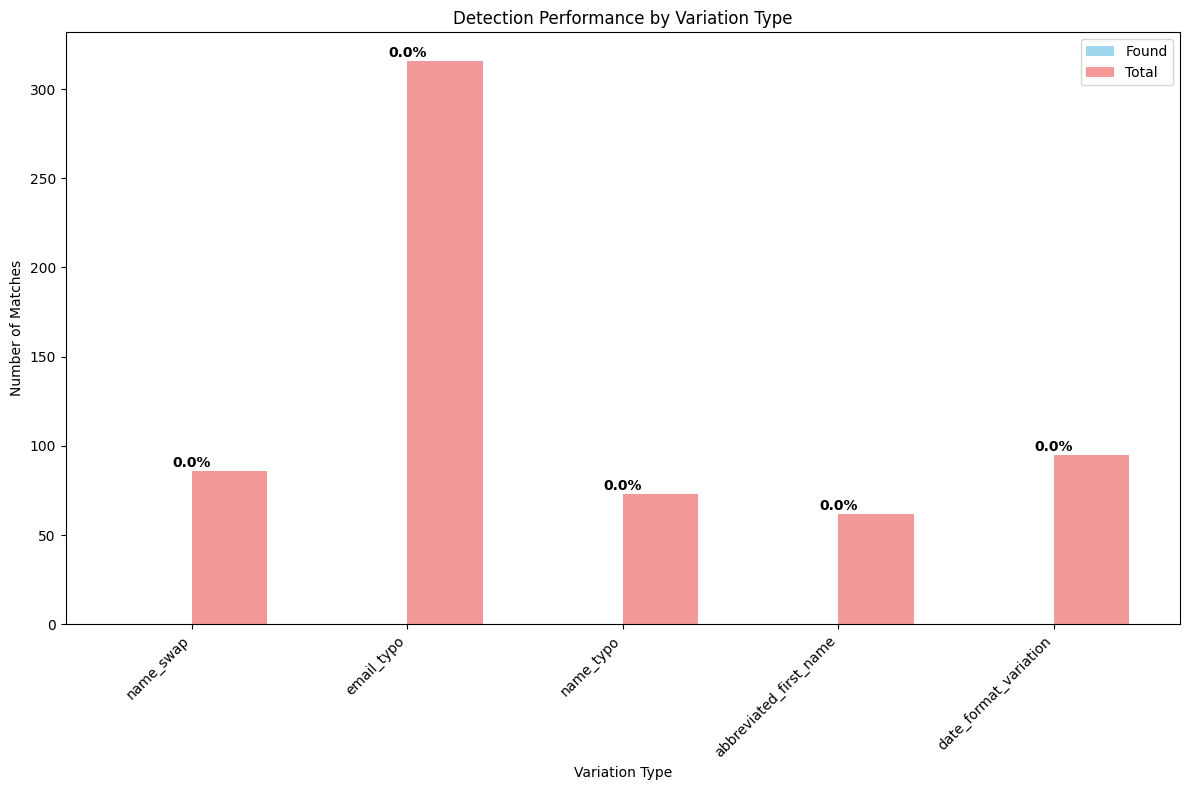

Detection Results by Variation Type:
--------------------------------------------------
name_swap                 |   0/ 86 (  0.0%)
email_typo                |   0/316 (  0.0%)
name_typo                 |   0/ 73 (  0.0%)
abbreviated_first_name    |   0/ 62 (  0.0%)
date_format_variation     |   0/ 95 (  0.0%)
--------------------------------------------------
Overall                   |   0/632 (  0.0%)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the golden standard data
golden_standard = pd.read_csv('data/test_golden_standard_low_updated.csv')

# Replace entity types to match your test data format
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

# Filter for Person entities (including HealthcarePersonnel)
person_variations = golden_standard[
    (golden_standard['entity_type'] == 'Person') | 
    (golden_standard['entity_type'] == 'HealthcarePersonnel')
]

# Create a mapping from ID pairs to variation types
variation_lookup = {}
for _, row in person_variations.iterrows():
    key = (row['original_id'], row['duplicate_id'])
    variation_lookup[key] = row['variation_type']

# Convert your found results back to ID pairs
# Assuming 'found' contains tuples like ('id1', 'id2')
found_with_variation = {}

for pair in found:
    if pair in variation_lookup:
        var_type = variation_lookup[pair]
        if var_type not in found_with_variation:
            found_with_variation[var_type] = 0
        found_with_variation[var_type] += 1

# Calculate totals for each variation type
variation_totals = {}
for var_type in person_variations['variation_type'].unique():
    variation_totals[var_type] = len(person_variations[person_variations['variation_type'] == var_type])

# Prepare data for plotting
variation_types = list(variation_totals.keys())
found_counts = [found_with_variation.get(vt, 0) for vt in variation_types]
total_counts = [variation_totals[vt] for vt in variation_types]

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(variation_types))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], found_counts, width, label='Found', alpha=0.8, color='skyblue')
bars2 = ax.bar([i + width/2 for i in x], total_counts, width, label='Total', alpha=0.8, color='lightcoral')

# Add percentage labels on bars
for i, (found, total) in enumerate(zip(found_counts, total_counts)):
    percentage = (found / total * 100) if total > 0 else 0
    ax.text(i, max(found, total) + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Variation Type')
ax.set_ylabel('Number of Matches')
ax.set_title('Detection Performance by Variation Type')
ax.set_xticks(x)
ax.set_xticklabels(variation_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results
print("Detection Results by Variation Type:")
print("-" * 50)
for var_type in variation_types:
    found_count = found_with_variation.get(var_type, 0)
    total_count = variation_totals[var_type]
    percentage = (found_count / total_count * 100) if total_count > 0 else 0
    print(f"{var_type:25} | {found_count:3d}/{total_count:3d} ({percentage:5.1f}%)")

print("-" * 50)
total_found = sum(found_counts)
total_possible = sum(total_counts)
overall_percentage = (total_found / total_possible * 100) if total_possible > 0 else 0
print(f"{'Overall':25} | {total_found:3d}/{total_possible:3d} ({overall_percentage:5.1f}%)")

In [36]:
import pandas as pd 
golden_standard = pd.read_csv('data/test_golden_standard_low_updated.csv')


golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_test = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_test:
        ground_truth_test[key] = []
    ground_truth_test[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

test_GT_Person = ground_truth_test['Person']
test_GT_HealthcareOrg = ground_truth_test['HealthcareOrganization']
test_GT_ServiceDept = ground_truth_test['ServiceDepartment']
test_GT_Address = ground_truth_test['Address']
test_GT_ContactPoint = ground_truth_test['ContactPoint']

In [37]:
test_GT_Person

[('http://example.org/Person/110a58a9-2956-4fbf-824e-fe9dbf9de014',
  'http://example.org/Person/0a023455-cdb5-4cfb-839c-bfd10399bdb7'),
 ('http://example.org/Person/53163b07-5e76-41ec-ad6f-4334d70e4112',
  'http://example.org/Person/238580c4-a754-4cae-9e3b-7ed20f3b5aac'),
 ('http://example.org/Person/b383854d-627f-4c49-857f-af3a7efb31c7',
  'http://example.org/Person/26381fb5-1e03-496d-b5ba-343ed2ffaec1'),
 ('http://example.org/Person/7600c884-fea7-4d63-8522-66ba0f493112',
  'http://example.org/Person/930c8e45-8a8e-4b82-83e7-d46ca8582343'),
 ('http://example.org/Person/b4eb1e34-302a-4879-a68b-ef2d33e10a93',
  'http://example.org/Person/639cdc9a-82b3-4a92-b58b-b92de2b80e2d'),
 ('http://example.org/Person/16f27279-01c6-423f-aeea-933030b91497',
  'http://example.org/Person/ce073a94-3280-46d9-ad94-c844eccad593'),
 ('http://example.org/Person/93515f5e-cfd3-42bf-8c31-47ab1f829322',
  'http://example.org/Person/4d7bac06-3d6b-4e04-9e4a-1689c2622ff3'),
 ('http://example.org/Person/b6478818-3a5

In [ ]:
import random


def sample_distinct_pairs(golden_standard_subset, ground_truth_pairs, entity_type, n_neg=3):
    """Sample distinct pairs for dedupe.io (negatives), avoiding ground truth."""
    filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity_type]
    all_ids1 = filtered['original_id'].unique()
    all_ids2 = filtered['duplicate_id'].unique()
    gt_set = set(ground_truth_pairs)
    distinct_pairs = set()
    attempts = 0
    max_attempts = len(gt_set) * n_neg * 10  # Prevent infinite loop
    
    while len(distinct_pairs) < len(gt_set) * n_neg and attempts < max_attempts:
        a, b = random.choice(all_ids1), random.choice(all_ids2)
        if (a, b) not in gt_set and (b, a) not in gt_set and (a, b) not in distinct_pairs:
            distinct_pairs.add((f"http://example.org/{entity_type}/{a}", f"http://example.org/{entity_type}/{b}"))
        attempts += 1
    return list(distinct_pairs)


for file in train_gs_files:
    golden_standard = pd.read_csv(file)
    golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]
    entity_types = ['Address', 'Person', 'HealthcareOrg', 'ServiceDept', 'ContactPoint']
    distinct_pairs = {}
    for entity_type in entity_types:
        negatives = sample_distinct_pairs(
            golden_standard_subset, ground_truth_train[entity_type], entity_type, n_neg=3
        )
        distinct_pairs[entity_type] = negatives

DP_Ad = distinct_pairs['Address'][:20]   
DP_Person = distinct_pairs['Person'][:20]
DP_HCO = distinct_pairs['HealthcareOrg'][:20]
DP_SD = distinct_pairs['ServiceDept'][:20]
DP_CP = distinct_pairs['ContactPoint'][:20]
